In [1]:
import pandas as pd
import os
import numpy as np
from pyproj import Transformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import gc
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from haversine import haversine, Unit
from shapely.ops import unary_union
from geopy.distance import geodesic
from shapely.geometry import Point
import random
from itertools import combinations
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import AgglomerativeClustering
from pyproj import Transformer
from geopy.geocoders import Nominatim
random.seed(42)
np.random.seed(42)
# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Data Cleaning

In [2]:
save_dir = r'data\ssusa'
os.makedirs(save_dir, exist_ok=True)

# Define the directory path
data_dir = save_dir

# Define file paths
sequences_path = data_dir + r'\ssusa_finalsequences.csv'
deployments_path = data_dir + r'\ssusa_finaldeployments.csv'

# Load the CSV files
sequences_df = pd.read_csv(
    sequences_path,
    na_values=["NA", " "],
    dtype={
        "Year": "Int64",
        "Sequence_ID": "object",
        "Group_Size": "Int64",
    },
    keep_default_na=True,
    parse_dates=["Start_Time", "End_Time"]
)
print(f"Number of records in sequences_df: {len(sequences_df)}")
deployments_df = pd.read_csv(
    deployments_path,
    na_values=["NA", " "],
    dtype={
        "Year": "Int64",
        "Survey_Nights": "float64", 
        "Latitude": "float64",
        "Longitude": "float64",
    },
    keep_default_na=True,
    parse_dates=["Start_Date", "End_Date"]
)
print(f"Number of records in deployments_df: {len(deployments_df)}")

Number of records in sequences_df: 987979
Number of records in deployments_df: 9679


In [3]:
# List of required columns
required_cols = ['Class', 'Order', 'Family', 'Genus', 'Species', 'Common_Name']

# Replace single space strings with actual NaN
sequences_df[required_cols] = sequences_df[required_cols].replace(' ', pd.NA)

# Count before filtering
initial_count = len(sequences_df)

# Drop rows with any missing values in required columns
sequences_df = sequences_df.dropna(subset=required_cols)

# Count after filtering
final_count = len(sequences_df)
deleted_count = initial_count - final_count

# Print results
print(f"Number of records deleted: {deleted_count}")
print(f"Final number of records: {final_count}")

Number of records deleted: 96032
Final number of records: 891947


In [4]:
# Get all common columns
common_cols = set(sequences_df.columns).intersection(deployments_df.columns)
print(common_cols)

# Merge on both 'Deployment_ID' and 'Year'
merged_df = pd.merge(
    sequences_df, 
    deployments_df, 
    on=list(common_cols), 
    how='inner'
)

merged_df = merged_df.drop_duplicates()

print(f"Number of records in merged_df: {len(merged_df)}")

{'Camera_Trap_Array', 'Year', 'Project', 'Deployment_ID'}
Number of records in merged_df: 885087


In [5]:
# Columns to convert to Proper Case
prop_case_cols = [
    'Class', 'Order', 'Family', 'Genus', 'Species', 'Habitat', 
    'Development_Level', 'Feature_Type', 'Common_Name', 'Age', 'Sex'
]

# First, replace blank or whitespace-only strings with NaN for Age, Sex, and Group_Size
merged_df[['Age', 'Sex', 'Group_Size']] = merged_df[['Age', 'Sex', 'Group_Size']].replace(r'^\s*$', pd.NA, regex=True)

# Group_Size: Replace missing with 0 and convert to numeric
merged_df['Group_Size'] = merged_df['Group_Size'].fillna(0)
merged_df['Group_Size'] = pd.to_numeric(merged_df['Group_Size'], errors='coerce').fillna(0).astype(int)

# Age and Sex: Replace missing with 'Unknown'
merged_df['Age'] = merged_df['Age'].fillna('Unknown')
merged_df['Sex'] = merged_df['Sex'].fillna('Unknown')

# Now apply proper case to selected columns
for col in prop_case_cols:
    merged_df[col] = merged_df[col].str.lower()

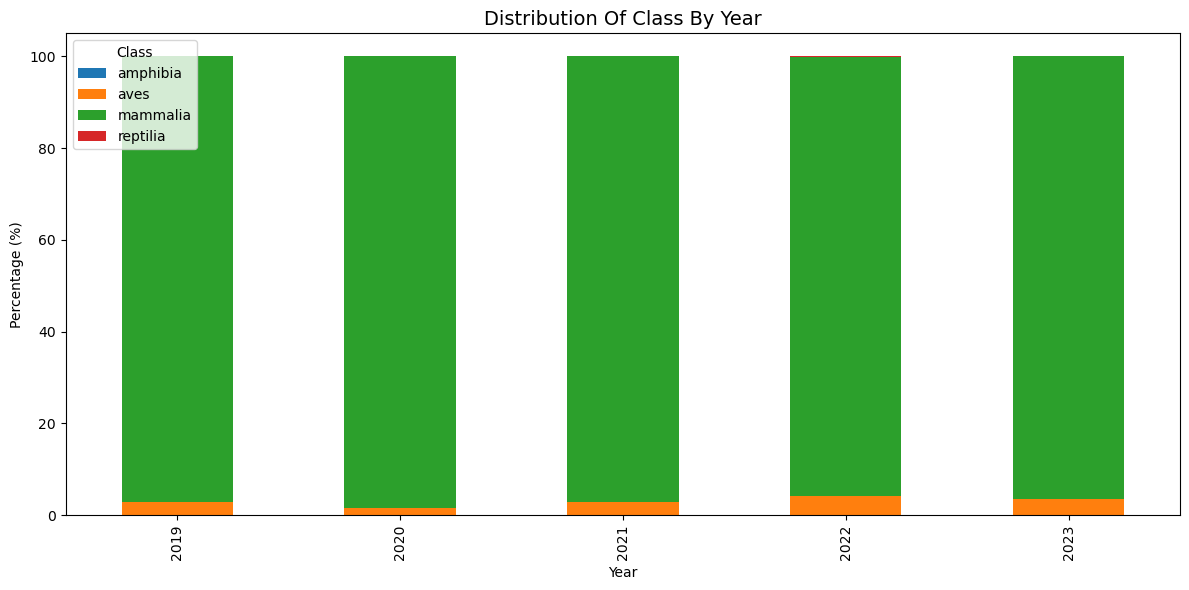

In [6]:
# Step 1: Group by Year and Class, count records
class_year_counts = (
    merged_df.groupby(['Year', 'Class'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Convert to percentages row-wise
class_year_pct = class_year_counts.div(class_year_counts.sum(axis=1), axis=0) * 100

# Step 3: Plot 100% stacked bar chart
class_year_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title("Distribution Of Class By Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend(title="Class", loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
# Only choose Mammals
merged_df = merged_df[merged_df['Class'] == 'mammalia']

# Drop all human data
merged_df = merged_df[
    (merged_df['Genus'].str.lower() != 'homo') &
    (merged_df['Species'].str.lower() != 'sapiens')
].reset_index(drop=True)

print(f"Number of records in merged_df: {len(merged_df)}")
print(f"Number of columns in merged_df: {merged_df.shape[1]}")

Number of records in merged_df: 772478
Number of columns in merged_df: 25


In [8]:
merged_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,Genus,Species,Common_Name,Age,Sex,Group_Size,Site_Name,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019-08-31 06:50:00,2019-08-31 06:50:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019-08-31 14:15:00,2019-08-31 14:17:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019-08-31 18:22:00,2019-08-31 18:22:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,adult,female,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,juvenile,unknown,2,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source


## Clustering

In [9]:
# IMPORTANT PARAMETER
# Distance thereshold in KM
DISTANCE = 50
# Threshold for small clusters
min_points = 1  

In [10]:
deployments_df = deployments_df.drop_duplicates(subset='Deployment_ID', keep='first')

deployments_df = deployments_df[deployments_df['Deployment_ID'].isin(merged_df['Deployment_ID'])]

def latlon_to_utm_zone(lat, lon):
    utm_zone = int((lon + 180) / 6) + 1
    is_northern = lat >= 0
    epsg_code = 32600 + utm_zone if is_northern else 32700 + utm_zone
    return epsg_code

# Example: pick appropriate UTM zone dynamically
mean_lat = deployments_df['Latitude'].mean()
mean_lon = deployments_df['Longitude'].mean()
utm_epsg = latlon_to_utm_zone(mean_lat, mean_lon)

transformer = Transformer.from_crs("epsg:4326", f"epsg:{utm_epsg}", always_xy=True)

deployments_df['x'], deployments_df['y'] = transformer.transform(
    deployments_df['Longitude'].values,
    deployments_df['Latitude'].values
)

agglo = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=DISTANCE*1000, # Convert km to meters
    linkage='complete'  # Ensures max pairwise distance within cluster <= threshold
)

deployments_df['Cluster_Agglo'] = agglo.fit_predict(deployments_df[['x', 'y']])

deployments_df.head()

,Year,Project,Camera_Trap_Array,Site_Name,Deployment_ID,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type,x,y,Cluster_Agglo
0,2022,Lex SKUNK,Sovie,Harrods Hill,Harrods Hill 08/06/2022,2022-09-01,2022-10-29,58.0,38.0164,-84.5642,Anthropogenic,Urban,Trail game,1.241122e+06,4.241374e+06,38
1,2022,Lex SKUNK,Sovie,Idle Hour,Idle Hour 08/06/2022,2022-09-01,2022-10-28,57.0,38.0200,-84.4586,Anthropogenic,Urban,Trail game,1.250379e+06,4.242629e+06,38
2,2022,Lex SKUNK,Sovie,Jacobson Park,Jacobson Park 08/06/2022,2022-09-01,2022-10-29,58.0,37.9886,-84.4158,Anthropogenic,Urban,Trail game,1.254470e+06,4.239485e+06,38
3,2022,Lex SKUNK,Sovie,Lake View,Lake View 08/06/2022,2022-09-03,2022-10-30,57.0,38.0125,-84.4705,Anthropogenic,Urban,Trail game,1.249408e+06,4.241698e+06,38
4,2022,Lex SKUNK,Sovie,Lexington Cemetery,Lexington Cemetery 09/30/2022,2022-10-01,2022-10-30,29.0,38.0630,-84.5124,Anthropogenic,Urban,Other,1.245204e+06,4.246976e+06,38


In [11]:
# Step 1: Create GeoDataFrame from deployments_df
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Step 2: Count points per cluster
cluster_counts = gdf['Cluster_Agglo'].value_counts()
min_points = min_points  # Threshold for small clusters
small_clusters = cluster_counts[cluster_counts < min_points].index.tolist()
large_clusters = cluster_counts[cluster_counts >= min_points].index.tolist()

# Step 3: Compute centroids of clusters (in lat/lon)
centroids = (
    gdf.groupby('Cluster_Agglo')['geometry']
    .apply(lambda x: unary_union(x).centroid)
    .reset_index()
)
centroids.columns = ['Cluster_Agglo', 'geometry']
centroids['coords'] = centroids['geometry'].apply(lambda point: (point.y, point.x))  # (lat, lon)

# Step 4: Map small clusters to nearest large cluster centroid
reassignment_map = {}

for small in small_clusters:
    small_coord = centroids.loc[centroids['Cluster_Agglo'] == small, 'coords'].values[0]

    # Find nearest large cluster centroid using geodesic distance
    nearest_cluster = min(
        large_clusters,
        key=lambda lc: geodesic(
            small_coord,
            centroids.loc[centroids['Cluster_Agglo'] == lc, 'coords'].values[0]
        ).kilometers
    )
    reassignment_map[small] = nearest_cluster

# Step 5: Reassign small cluster points to nearest large cluster
def reassign_cluster(row):
    if row['Cluster_Agglo'] in reassignment_map:
        return reassignment_map[row['Cluster_Agglo']]
    return row['Cluster_Agglo']

gdf['Cluster_Agglo_Updated'] = gdf.apply(reassign_cluster, axis=1)

# If you want to update deployments_df with new cluster assignments:
deployments_df['Cluster_Agglo'] = gdf['Cluster_Agglo_Updated']

In [12]:
# Get unique updated cluster IDs and sort them
unique_clusters = sorted(deployments_df['Cluster_Agglo'].unique())

# Create mapping from old cluster ID → new sequential ID
new_cluster_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_clusters)}

# Apply mapping
deployments_df['Cluster_Agglo'] = deployments_df['Cluster_Agglo'].map(new_cluster_id_map)

In [13]:
# Get frequency counts sorted by cluster ID
freq = deployments_df['Cluster_Agglo'].value_counts().sort_index()

# Convert to DataFrame and add serial number starting from 1
freq_df = freq.reset_index()
freq_df.columns = ['Cluster_Agglo', 'Frequency']
freq_df.insert(0, 'Serial_No', range(1, len(freq_df) + 1))

print(freq_df)

     Serial_No  Cluster_Agglo  Frequency
0            1              0         37
1            2              1        111
2            3              2         59
3            4              3         33
4            5              4         31
..         ...            ...        ...
206        207            206          8
207        208            207         18
208        209            208        197
209        210            209         90
210        211            210          8

[211 rows x 3 columns]


In [14]:
gc.collect()

0

In [15]:
print(len(deployments_df))

9380


In [16]:
# Perform the join
merged_df = merged_df.merge(
    deployments_df[['Deployment_ID', 'Cluster_Agglo']],  
    on='Deployment_ID',
    how='left'  
)
print(f"Number of records in merged_df: {len(merged_df)}")
print(f"Number of columns in merged_df: {merged_df.shape[1]}")

Number of records in merged_df: 772478
Number of columns in merged_df: 26


In [17]:
# Create GeoDataFrame from deployments_df
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)

# Compute centroids
centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)
centroids_gdf = gpd.GeoDataFrame(centroids, geometry='geometry', crs=gdf.crs).reset_index()

C:\Users\cliff\AppData\Local\Temp\ipykernel_22860\72540679.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)


In [18]:
# Convert centroids_gdf geometry back to lat/lon (EPSG:4326)
centroids_gdf_latlon = centroids_gdf.to_crs(epsg=4326)

# Add columns for latitude and longitude
centroids_gdf_latlon['Centroid_Latitude'] = centroids_gdf_latlon.geometry.y
centroids_gdf_latlon['Centroid_Longitude'] = centroids_gdf_latlon.geometry.x

centroids_gdf_latlon.head()

,Cluster_Agglo,geometry,Centroid_Latitude,Centroid_Longitude
0,0,POINT (-122.94104 47.87268),47.872681,-122.941040
1,1,POINT (-73.81147 40.7944),40.794404,-73.811474
2,2,POINT (-75.61989 39.73539),39.735393,-75.619889
3,3,POINT (-96.76898 40.75618),40.756180,-96.768980
4,4,POINT (-79.37719 36.05311),36.053106,-79.377192


In [19]:
# Add Cnetroid latitude and longitude back to the dataframe
merged_df = merged_df.merge(
    centroids_gdf_latlon[['Centroid_Latitude', 'Centroid_Longitude', 'Cluster_Agglo']],  
    on='Cluster_Agglo',
    how='left'  
)

In [20]:
merged_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,Genus,Species,Common_Name,Age,Sex,Group_Size,Site_Name,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type,Cluster_Agglo,Centroid_Latitude,Centroid_Longitude
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019-08-31 06:50:00,2019-08-31 06:50:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019-08-31 14:15:00,2019-08-31 14:17:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019-08-31 18:22:00,2019-08-31 18:22:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,adult,female,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,juvenile,unknown,2,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876


## Clustering vizualization

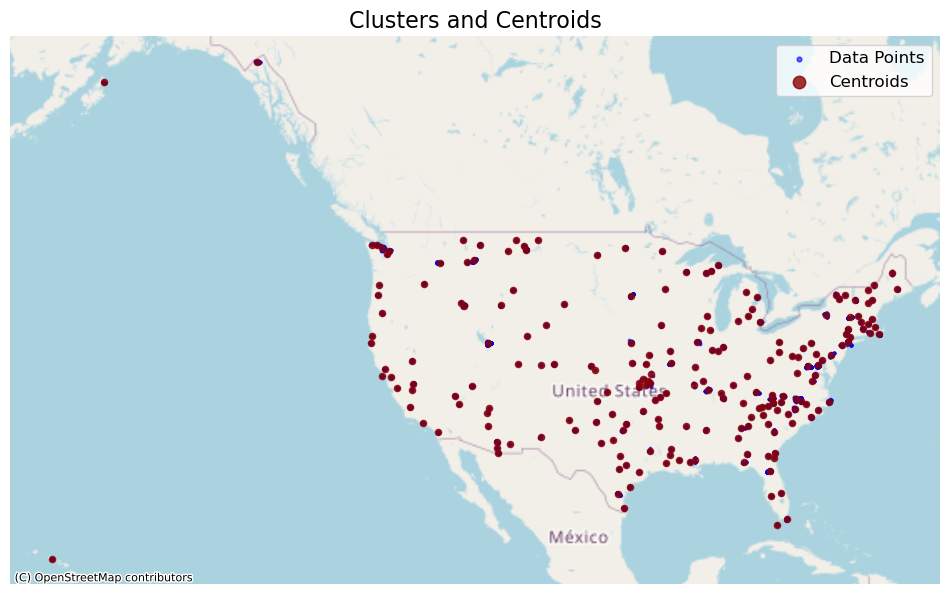

In [21]:
# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot datapoints as small blue dots
gdf.plot(ax=ax, color='blue', markersize=3, alpha=0.6, label='Data Points')

# Plot centroids as larger dark red dots
centroids_gdf.plot(ax=ax, color='darkred', alpha=0.8, markersize=20, label='Centroids')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(markerscale=2, fontsize=12)

# Style
ax.set_title('Clusters and Centroids', fontsize=16)
ax.set_axis_off()
# plt.savefig(save_dir + r"\plots\Agglo_cluster_centroids.png", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\cliff\AppData\Local\Temp\ipykernel_22860\3552207275.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(cluster_ids_to_plot))


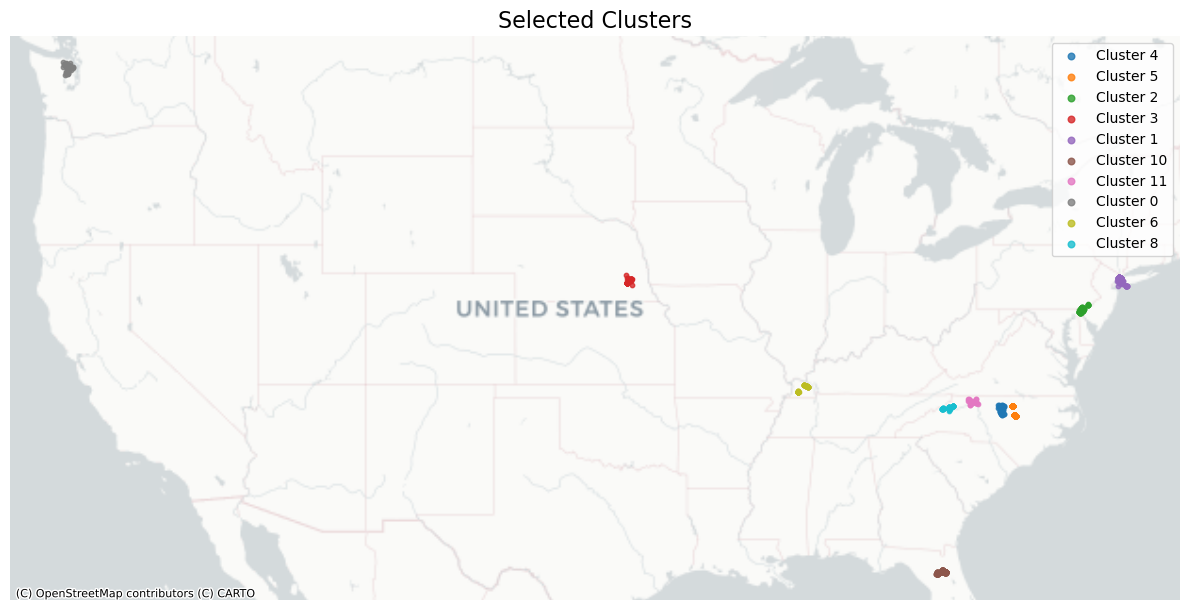

In [22]:
# === Replace with your actual cluster IDs ===
cluster_ids_to_plot = [4,	5,	2,	3,	1,	10,	11,	0,	6,	8]

# Create GeoDataFrame if not already done
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (for basemap compatibility)
gdf = gdf.to_crs(epsg=3857)

# Filter only selected clusters
gdf_subset = gdf[gdf['Cluster_Agglo'].isin(cluster_ids_to_plot)]

# Set up plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define color map
cmap = cm.get_cmap('tab10', len(cluster_ids_to_plot))

# Plot each cluster with unique color
for i, cluster_id in enumerate(cluster_ids_to_plot):
    cluster_data = gdf_subset[gdf_subset['Cluster_Agglo'] == cluster_id]
    cluster_data.plot(ax=ax, markersize=10, color=cmap(i), label=f'Cluster {cluster_id}', alpha=0.8)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Styling
ax.set_title("Selected Clusters", fontsize=16)
ax.legend(markerscale=1.5, fontsize=10)
ax.set_axis_off()

plt.tight_layout()
# plt.savefig(save_dir + r"\plots\Agglo_cluster_top10_max_dist.png", dpi=600, bbox_inches='tight')
plt.show()

In [23]:
#Cluster metrics
def cluster_distance_stats_df(
    df,
    cluster_col='Cluster_KMeans',
    lat_col='Latitude',
    lon_col='Longitude',
    # output_dir=save_dir
):
    clusters = df[cluster_col].unique()
    results = []

    for c in sorted(clusters):
        cluster_points = df[df[cluster_col] == c][[lat_col, lon_col]].values
        
        count = len(cluster_points)
        if count < 2:
            results.append({
                'cluster_id': c,
                'count': count,
                'min_distance_km': np.nan,
                'avg_distance_km': np.nan,
                'max_distance_km': np.nan
            })
            continue
        
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).km
            for (lat1, lon1), (lat2, lon2) in combinations(cluster_points, 2)
        ]
        
        results.append({
            'cluster_id': c,
            'count': count,
            'min_distance_km': min(distances),
            'avg_distance_km': sum(distances) / len(distances),
            'max_distance_km': max(distances)
        })
    
    Output = pd.DataFrame(results).sort_values('cluster_id').reset_index(drop=True)
    
    # Ensure directory exists
    # os.makedirs(output_dir, exist_ok=True)
    
    # Full path for output file
    # filename = f"{cluster_col}.xlsx"
    # filepath = os.path.join(output_dir, filename)
    
    # Output.to_excel(filepath, index=False)
    
    return Output

In [24]:
cluster_stats_df = cluster_distance_stats_df(
    deployments_df, 
    cluster_col='Cluster_Agglo'
)
print(cluster_stats_df)

     cluster_id  count  min_distance_km  avg_distance_km  max_distance_km
0             0     37         0.000000        19.606523        46.429164
1             1    111         0.000000        16.389561        46.884951
2             2     59         0.000204        16.677386        47.073118
3             3     33         0.193766        14.221075        46.940625
4             4     31         0.187133        20.079045        47.491956
..          ...    ...              ...              ...              ...
206         206      8         1.725046         5.550185        10.223269
207         207     18         0.204837         0.739182         1.529797
208         208    197         0.000000         6.403474        18.161343
209         209     90         0.000000         3.761261         7.459072
210         210      8         0.131273         0.400653         0.834509

[211 rows x 5 columns]


In [25]:
cluster_stats_df.describe()

,cluster_id,count,min_distance_km,avg_distance_km,max_distance_km
count,211.00000,211.000000,211.000000,211.000000,211.000000
mean,105.00000,44.454976,0.529254,6.223410,15.069788
std,61.05462,49.406204,2.096698,6.327259,14.211661
min,0.00000,2.000000,0.000000,0.320037,0.665229
25%,52.50000,13.000000,0.000000,1.495705,3.210006
50%,105.00000,27.000000,0.000086,4.061090,10.223269
75%,157.50000,56.500000,0.234453,8.996617,23.383861
max,210.00000,373.000000,18.242840,28.853420,47.491956


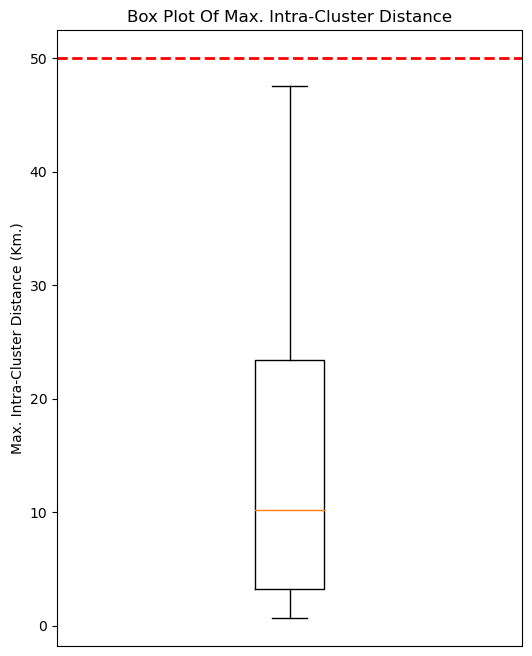

In [26]:
# Create figure and plot
# output_dir = save_dir + r"\plots"
# fig_path = os.path.join(output_dir, "BoxPlot_IntraCluster_Distance.png")
plt.figure(figsize=(6,8))  # Taller for vertical box plot

plt.boxplot(cluster_stats_df['max_distance_km'].dropna(), vert=True)

plt.title('Box Plot Of Max. Intra-Cluster Distance')
plt.ylabel('Max. Intra-Cluster Distance (Km.)')

# Remove x-axis labels/ticks
plt.xticks([])

# Add horizontal line at y=DISTANCE
plt.axhline(y=DISTANCE, color='red', linestyle='--', linewidth=2)

# Save the figure
# plt.savefig(fig_path, dpi=600, bbox_inches='tight')

# plt.savefig(save_dir + r"\plots\Agglo_cluster_boxplot_max_dist.png", dpi=600, bbox_inches='tight')
plt.show()

In [27]:
camera_array_clusters = merged_df.groupby('Camera_Trap_Array')['Cluster_Agglo'].unique()
for array, clusters in camera_array_clusters.items():
    if len(clusters) < 2:
        continue
    print(f"Camera Trap Array: {array}\nCluster IDs: {clusters}\n")

Camera Trap Array: Ahlers
Cluster IDs: [107  36 102 202  26  64  21  25  46]

Camera Trap Array: AustinPeay
Cluster IDs: [182  12]

Camera Trap Array: Elwha
Cluster IDs: [45 74  0]

Camera Trap Array: FortHays
Cluster IDs: [ 69 197]

Camera Trap Array: StLawrence
Cluster IDs: [20 34]



In [28]:
# Find clusters with only 1 point
single_point_clusters = freq_df[freq_df['Frequency'] == 1]['Cluster_Agglo'].tolist()
print("Clusters with only 1 point:", single_point_clusters)

Clusters with only 1 point: []


## Name the cluster

In [29]:
# Select relevant columns
subset = merged_df[['Latitude', 'Longitude', 'Cluster_Agglo']]

# Group by Cluster_Agglo and find mean lat/lon
cluster_means = subset.groupby('Cluster_Agglo')[['Latitude', 'Longitude']].mean().reset_index()

geolocator = Nominatim(user_agent="geoapi")

def get_city_state(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language='en')
        address = location.raw['address']
        city = next((address.get(k) for k in [
            'city', 'town', 'village', 'hamlet', 'municipality', 'locality', 'suburb', 'neighbourhood'
        ]), None)
        if city is None:
            city = address.get('county', 'Unknown')
        state = address.get('state', 'Unknown')
        return f"{city} - {state}"
    except Exception as e:
        # print(f"Error for {lat}, {lon}: {e}")
        return "Unknown, Unknown"

# Apply reverse geocoding to each cluster mean coordinate
cluster_means['City_State'] = cluster_means.apply(
    lambda row: get_city_state(row['Latitude'], row['Longitude']), axis=1
)

# Print pre and post record counts
print(f"Original records: {len(merged_df)}")
print(f"Clusters found: {len(cluster_means)}")

# Merge City_State back to original dataframe on Cluster_Agglo
merged_df = merged_df.merge(cluster_means[['Cluster_Agglo', 'City_State']], on='Cluster_Agglo', how='left')
print(f"After join: {len(merged_df)}")

Original records: 772478
Clusters found: 211
After join: 772478


## Add Scientific Name (Genus species)

In [30]:
merged_df['Sci_Name'] = merged_df['Genus'].str.capitalize() + ' ' + merged_df['Species']

In [31]:
merged_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,Genus,Species,Common_Name,Age,Sex,Group_Size,Site_Name,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type,Cluster_Agglo,Centroid_Latitude,Centroid_Longitude,City_State,Sci_Name
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019-08-31 06:50:00,2019-08-31 06:50:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019-08-31 14:15:00,2019-08-31 14:17:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019-08-31 18:22:00,2019-08-31 18:22:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,adult,female,1,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,juvenile,unknown,2,AK_Forest_Crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos


## Save Dataset

In [32]:
# !pip install XlsxWriter

In [33]:
output_path = data_dir + fr'\Data_Clustered_Cleaned_{DISTANCE}km_WithSciName.csv'
merged_df.to_csv(output_path, index=False)